In [1]:
import os
import sys
import random
import numpy as np
import cv2
import tensorflow as tf
from tensorflow import keras
import cv2
import matplotlib.pyplot as plt
from keras import backend as K
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix 
from sklearn.model_selection import KFold
from keras.applications.vgg16 import VGG16

In [2]:
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
import datetime
now = datetime.datetime.now

In [3]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose, multiply, Lambda, add, Activation,Dropout, BatchNormalization
from tensorflow.keras.layers import concatenate, Concatenate
from tensorflow.keras.optimizers import *
import keras.backend as K
from keras.callbacks import EarlyStopping
from keras.preprocessing import image
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
!pip install natsort

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
from os import listdir
import natsort 
import PIL
PIL.Image.MAX_IMAGE_PIXELS = 933120000

In [6]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [7]:
#paths of images and masks
train_img_path = '/content/gdrive/MyDrive/UNET-code/thumb'
train_mask_path = '/content/gdrive/MyDrive/UNET-code/annotations'
image_list = listdir(train_img_path)
mask_list = listdir(train_mask_path)
sorted_mlist = natsort.natsorted(mask_list)
sorted_imglist=natsort.natsorted(image_list)
num_imgs = len(sorted_imglist)
num_imgs

69

In [109]:
IMAGE_SIZE = 256
img_channels = 3
mask_channel = 1
epochs = 3
BATCH_SIZE = 16

In [9]:
input_img = (IMAGE_SIZE, IMAGE_SIZE, img_channels)
input_mask = (IMAGE_SIZE, IMAGE_SIZE,mask_channel)

In [10]:
def loadimages(dir_path,imglist,imgarray,inp_size):
  for i in range(num_imgs):
    temp = tf.keras.utils.load_img(os.path.join(dir_path, imglist[i]), target_size = inp_size)
    img = tf.keras.utils.img_to_array(temp)
    img = tf.image.resize(img, (IMAGE_SIZE,IMAGE_SIZE))
    imgarray[i] = img[:,:,:]/255.0
  return imgarray
def loadmasks(dir_path,imglist,imgarray,inp_size):
  for i in range(num_imgs):
    temp = tf.keras.utils.load_img(os.path.join(dir_path, imglist[i]), target_size = inp_size)
    img = tf.keras.utils.img_to_array(temp)
    img = tf.image.resize(img, (IMAGE_SIZE,IMAGE_SIZE))
    imgarray[i] = img[:,:,0]/255.0 
  imgarray = np.expand_dims(imgarray, axis=3)
  return imgarray

In [11]:
x = np.zeros((num_imgs, IMAGE_SIZE, IMAGE_SIZE,3),dtype=np.float32)
y = np.zeros((num_imgs,IMAGE_SIZE,IMAGE_SIZE),dtype=np.float32)

In [12]:
xtrain = loadimages(train_img_path, sorted_imglist, x, input_img)
ytrain = loadmasks(train_mask_path, sorted_mlist, y, input_mask)

In [13]:
''' Uncomment for visualization
plt.figure(figsize = (14,6))
plt.subplot(221)
plt.imshow(np.squeeze(images[0]))
plt.title('image 1')
plt.subplot(222)
plt.imshow(np.squeeze(masks[0]), cmap = "gray")
plt.title('mask 1')'''

' Uncomment for visualization\nplt.figure(figsize = (14,6))\nplt.subplot(221)\nplt.imshow(np.squeeze(images[0]))\nplt.title(\'image 1\')\nplt.subplot(222)\nplt.imshow(np.squeeze(masks[0]), cmap = "gray")\nplt.title(\'mask 1\')'

Augmentation

In [14]:
!pip install -U albumentations

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 123 kB 30.2 MB/s 
  Attempting uninstall: albumentations
    Found existing installation: albumentations 1.2.1
    Uninstalling albumentations-1.2.1:
      Successfully uninstalled albumentations-1.2.1


In [15]:
import albumentations as A
import cv2

transform = A.Compose([
    A.RandomCrop(width= IMAGE_SIZE, height=IMAGE_SIZE),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.1),
    A.Rotate(limit = 90),
])

In [16]:
img = []
msk = []
for i,j in enumerate(zip(xtrain,ytrain)):
  transformed = transform(image =np.array(j[0]), mask=np.array(j[1]))
  img.append(transformed['image'])
  msk.append(transformed['mask'])

In [17]:
img2 = []
msk2 = []
for i,j in enumerate(zip(xtrain,ytrain)):
  transformed = transform(image =np.array(j[0]), mask=np.array(j[1]))
  img2.append(transformed['image'])
  msk2.append(transformed['mask'])

In [18]:
img = np.array(img)
msk = np.array(msk)
img2 = np.array(img2)
msk2 = np.array(msk2)

Concatenate

In [19]:
xtrain = np.array(xtrain)
ytrain = np.array(ytrain)
Xtrain = np.append(xtrain,img, axis = 0)
Ytrain = np.append(ytrain,msk,axis = 0)

In [20]:
Xtrain = np.append(Xtrain,img2, axis = 0)
Ytrain = np.append(Ytrain,msk2,axis = 0)

In [21]:
Xtrain.shape

(207, 256, 256, 3)

In [22]:
Ytrain.shape

(207, 256, 256, 1)

Metrics

In [24]:
smooth = 1.
def dice_score(y_true, y_pred):
    # masks
    smooth = 1.
    y_true_fm = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_fm * y_pred_f)
    score = (2. * intersection + smooth) / (K.sum(y_true_fm) + K.sum(y_pred_f) + smooth) 
    return score

def dice_loss(y_true, y_pred):
    smooth = 1.
    y_true_fm = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_fm * y_pred_f)
    score = (2. * intersection + smooth) / (K.sum(y_true_fm) + K.sum(y_pred_f) + smooth)
    loss = 1-score
    return loss


In [111]:
def UNET(IMAGE_SIZE,num_channels):
  inputs = Input((IMAGE_SIZE, IMAGE_SIZE, num_channels))
  #s = Lambda(lambda x: x / 255)(inputs)   
  #No need for this if we normalize our inputs beforehand
  s = inputs

    #Contraction path
  c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
  c1 = Dropout(0.4)(c1)
  c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
  c1 = BatchNormalization()(c1)
  p1 = MaxPooling2D((2, 2))(c1)
    
  c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
  c2 = Dropout(0.4)(c2)
  c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
  c2 = BatchNormalization()(c2)
  p2 = MaxPooling2D((2, 2))(c2)
     
  c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
  c3 = Dropout(0.4)(c3)
  c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
  c3 = BatchNormalization()(c3)
  p3 = MaxPooling2D((2, 2))(c3)
     
  c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
  c4 = Dropout(0.4)(c4)
  c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
  c4 = BatchNormalization()(c4)
  p4 = MaxPooling2D(pool_size=(2, 2))(c4)
     
  c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
  c5 = Dropout(0.4)(c5)
  c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    
    #Expansive path 
  u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
  u6 = concatenate([u6, c4])
  c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
  c6 = Dropout(0.4)(c6)
  c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
     
  u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
  u7 = concatenate([u7, c3])
  c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
  c7 = Dropout(0.4)(c7)
  c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
     
  u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
  u8 = concatenate([u8, c2])
  c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
  c8 = Dropout(0.4)(c8)
  c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
     
  u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
  u9 = concatenate([u9, c1], axis=3)
  c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
  c9 = Dropout(0.4)(c9)
  c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
     
  outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
     
  model = Model(inputs=[inputs], outputs=[outputs])


  model.summary()
    
  return model

In [112]:
model = UNET(input_img)
model.compile(optimizer = tf.keras.optimizers.Adam(lr = 1e-8), loss = dice_loss, metrics = [dice_score])
#t = now()
callbacks = [EarlyStopping(monitor='loss', patience = 2)]
history = model.fit(x = Xtrain, y = Ytrain, batch_size=BATCH_SIZE,validation_split  = 0.20, epochs=epochs, verbose=1, callbacks=callbacks)

(None, 256, 256, 3)
(None, 256, 256, 64)
Epoch 1/3


/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


11/11 [==============================] - 12s 920ms/step - loss: 0.2802 - dice_score: 0.7197 - val_loss: 0.4387 - val_dice_score: 0.5615
Epoch 2/3
11/11 [==============================] - 9s 808ms/step - loss: 0.2803 - dice_score: 0.7198 - val_loss: 0.3912 - val_dice_score: 0.6090
Epoch 3/3
11/11 [==============================] - 9s 809ms/step - loss: 0.2802 - dice_score: 0.7200 - val_loss: 0.3599 - val_dice_score: 0.6403


In [113]:
test_path = '/content/gdrive/MyDrive/UNET-code/thumb-test'
test_mask_path = '/content/gdrive/MyDrive/UNET-code/annotations-test'
test_list = listdir(test_path)
tmsk_list = listdir(test_mask_path)
sorted_tmsk = natsort.natsorted(tmsk_list)
sorted_test=natsort.natsorted(test_list)
num_imgs = len(sorted_test)
num_imgs
num_msk = len(sorted_tmsk)

In [114]:
def loadmsk(dir_path,imglist,imgarray,inp_size):
  for i in range(num_msk):
    temp = tf.keras.utils.load_img(os.path.join(dir_path, imglist[i]), target_size = inp_size)
    img = tf.keras.utils.img_to_array(temp)
    img = tf.image.resize(img, (IMAGE_SIZE,IMAGE_SIZE))
    imgarray[i] = img[:,:,0]/255.0 
  imgarray = np.expand_dims(imgarray, axis=3)
  return imgarray

In [115]:
xtest = np.zeros((num_imgs, IMAGE_SIZE, IMAGE_SIZE,3),dtype=np.float32)
ytest = np.zeros((num_msk,IMAGE_SIZE,IMAGE_SIZE),dtype=np.float32)

In [116]:
testimg = loadimages(test_path, sorted_test, xtest, input_img)
testmsk = loadmsk(test_mask_path, sorted_tmsk, ytest, input_mask)
print("images", testimg.shape)
print("masks", testmsk.shape)

images (14, 256, 256, 3)
masks (8, 256, 256, 1)


In [124]:
t = now()
preds = model.predict(testimg)
#preds = (preds < 0.62).astype(np.uint8)
print('Testing time: %s' % (now() - t))

1/1 [==============================] - 0s 23ms/step
Testing time: 0:00:00.326007


In [118]:
preds[9] = preds[9] > 0.65

In [119]:
num_disp = 3

Text(0.5, 1.0, 'Image')

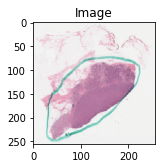

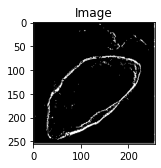

In [120]:
plt.figure(figsize = (10,15))
plt.subplot(num_disp,4,1)
plt.imshow(np.squeeze(testimg[9]))
plt.title('Image')
plt.title('Image')
plt.figure(figsize = (10,15))
plt.subplot(num_disp,4,1)
plt.imshow(np.squeeze(preds[9]),cmap = 'gray')
plt.title('Image')

In [125]:
preds[10] = (preds[10] > 0.67).astype(np.uint8)

Text(0.5, 1.0, 'Image')

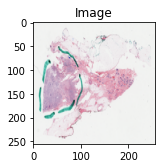

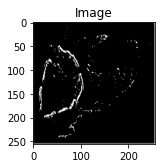

In [126]:
plt.figure(figsize = (10,15))
plt.subplot(num_disp,4,1)
plt.imshow(np.squeeze(testimg[10]))
plt.title('Image')
plt.figure(figsize = (10,15))
plt.subplot(num_disp,4,1)
plt.imshow(np.squeeze(preds[10]),cmap = 'gray')
plt.title('Image')

In [105]:
preds[11] = (preds[11] > 0.65).astype(np.uint8)

Text(0.5, 1.0, 'Image')

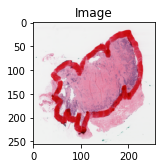

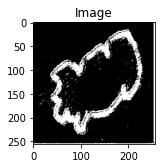

In [106]:
plt.figure(figsize = (10,15))
plt.subplot(num_disp,4,1)
plt.imshow(np.squeeze(testimg[11]))
plt.title('Image')
plt.figure(figsize = (10,15))
plt.subplot(num_disp,4,1)
plt.imshow(np.squeeze(preds[11]),cmap = 'gray')
plt.title('Image')